# **Group 37: DSCI 100 - Physical Characteristics of Tennis Players Influencing their Likelihood of Winning Matches**

----------------------------------------------------------


## Research question: do tennis players' physical characteristics influence the likelihood of winning a game?


## Introduction
Our project aims to identify the likelihood of winning (or losing) tennis matches in the ATP tournament based on a player’s physical characteristics such as height and age. Our dataset is taken from [Jeff Sackmann’s tennis database on GitHub](https://github.com/JeffSackmann/tennis_atp) and compiles ATP tournament match data from 2020. The ATP Tour is a global top-level male tennis tour organised by the Association of Tennis Professionals (ATP). 

While our dataset contains 50 columns and almost 7000 rows, we are whittling this down to focus on exclusively physical characteristic data of players. We have also created a new binary variable, `win_lose`, which indicates the overall result of a tennis match. Our project will focus on a $K$-nearest neighbours classification analysis of our two classifier variables and our one predictor variable. We will try to predict the outcome of  a match based on players' age and height.



In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(RCurl)
options(repr.matrix.max.rows = 6)
set.seed(1)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#reading the dataset into Jupyter
x <- getURL("https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2020.csv")
match_data <- read.csv(text = x)
match_data #table 1.1

tourney_id,tourney_name,surface,draw_size,tourney_level,tourney_date,match_num,winner_id,winner_seed,winner_entry,⋯,l_1stIn,l_1stWon,l_2ndWon,l_SvGms,l_bpSaved,l_bpFaced,winner_rank,winner_rank_points,loser_rank,loser_rank_points
<chr>,<chr>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
2020-8888,Atp Cup,Hard,24,A,20200106,300,104925,NA,,⋯,51,39,6,10,6,8,2,9055,1,9985
2020-8888,Atp Cup,Hard,24,A,20200106,299,105138,NA,,⋯,35,21,6,9,5,10,10,2335,34,1251
2020-8888,Atp Cup,Hard,24,A,20200106,298,104925,NA,,⋯,57,35,25,14,6,11,2,9055,5,5705
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
2020-7485,Antwerp,Hard,32,A,20201019,128,126203,7,,⋯,37,30,5,9,3,5,28,1670,33,1402
2020-7485,Antwerp,Hard,32,A,20201019,129,144750,NA,Q,⋯,45,29,5,10,7,11,90,748,74,838
2020-7485,Antwerp,Hard,32,A,20201019,130,200005,NA,,⋯,32,26,7,9,2,4,38,1306,172,353


In [3]:
#Split match_data into two tables based on whether a player won or lost their match
#Add a variable indicating said win or loss
#Select for the variables of interest: height and age and match_result
#Rename height and age column names to remove redundancy and improve consistency
match_data_winner <- match_data |> 
                    mutate(match_result = "win") |>
                    select(winner_ht, winner_age, match_result) |>
                    rename(ht = winner_ht, age = winner_age)

match_data_loser <- match_data |> 
                    mutate(match_result = "lose") |>
                    select(loser_ht, loser_age, match_result) |>
                    rename(ht = loser_ht, age = loser_age)

#Recombine the two tables into one
match_data_tidy <- bind_rows(match_data_winner, match_data_loser)
match_data_tidy #table 1.2

ht,age,match_result
<int>,<dbl>,<chr>
188,32.6,win
183,31.7,win
188,32.6,win
⋮,⋮,⋮
211,23.1,lose
178,21.5,lose
180,26.6,lose


In [4]:
#Seperating the Data into training and test sets, with a training/testing split of 75/25% based on the match result
match_split <- initial_split(match_data_tidy, prop = 0.75, strata = match_result)
match_train <- training(match_split)
match_test <- testing(match_split)

In [5]:
#Check number of missing values in each column of the table ONLY USING TRAINING DATA
num_na <- match_train |> 
            summarize_all(~sum(is.na(.)))
num_na #table 1.3

ht,age,match_result
<int>,<int>,<int>
36,0,0


In [6]:
#remove NA tuples from datasets
match_train <- filter(match_train, !is.na(ht))
match_test <- filter(match_test, !is.na(ht))

**NOTE**: 
Of the 2934 tuples in our dataset, 36 of them have a NA value in one of the variables of interest. Thats only slightly more than 1% of the data, so the dataset is still suitable for analysis.

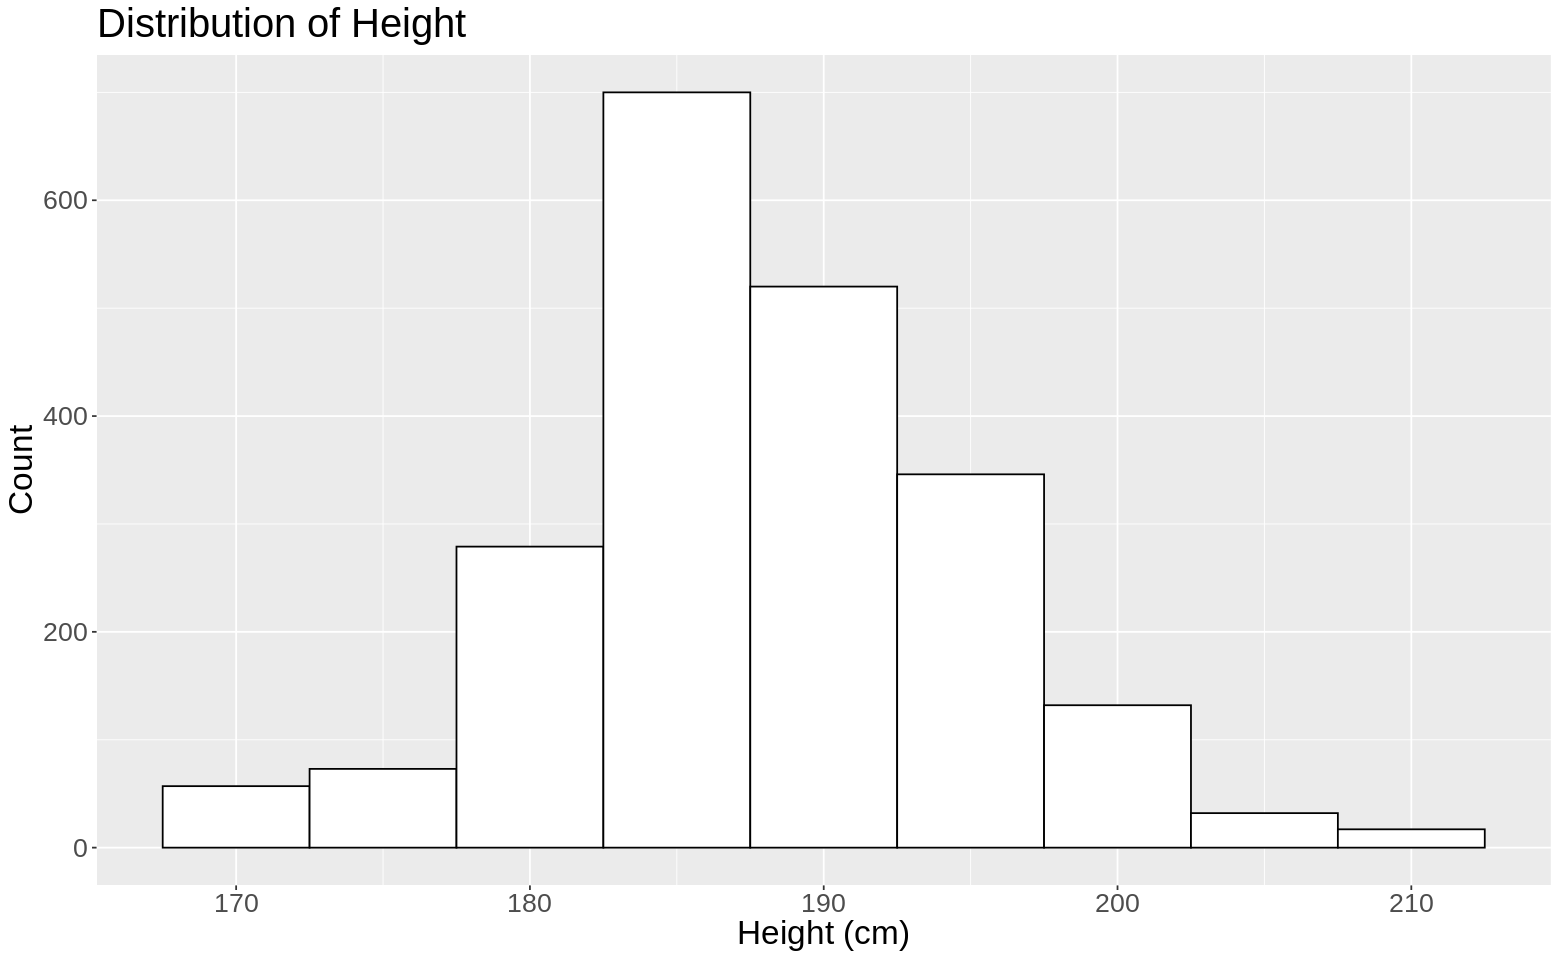

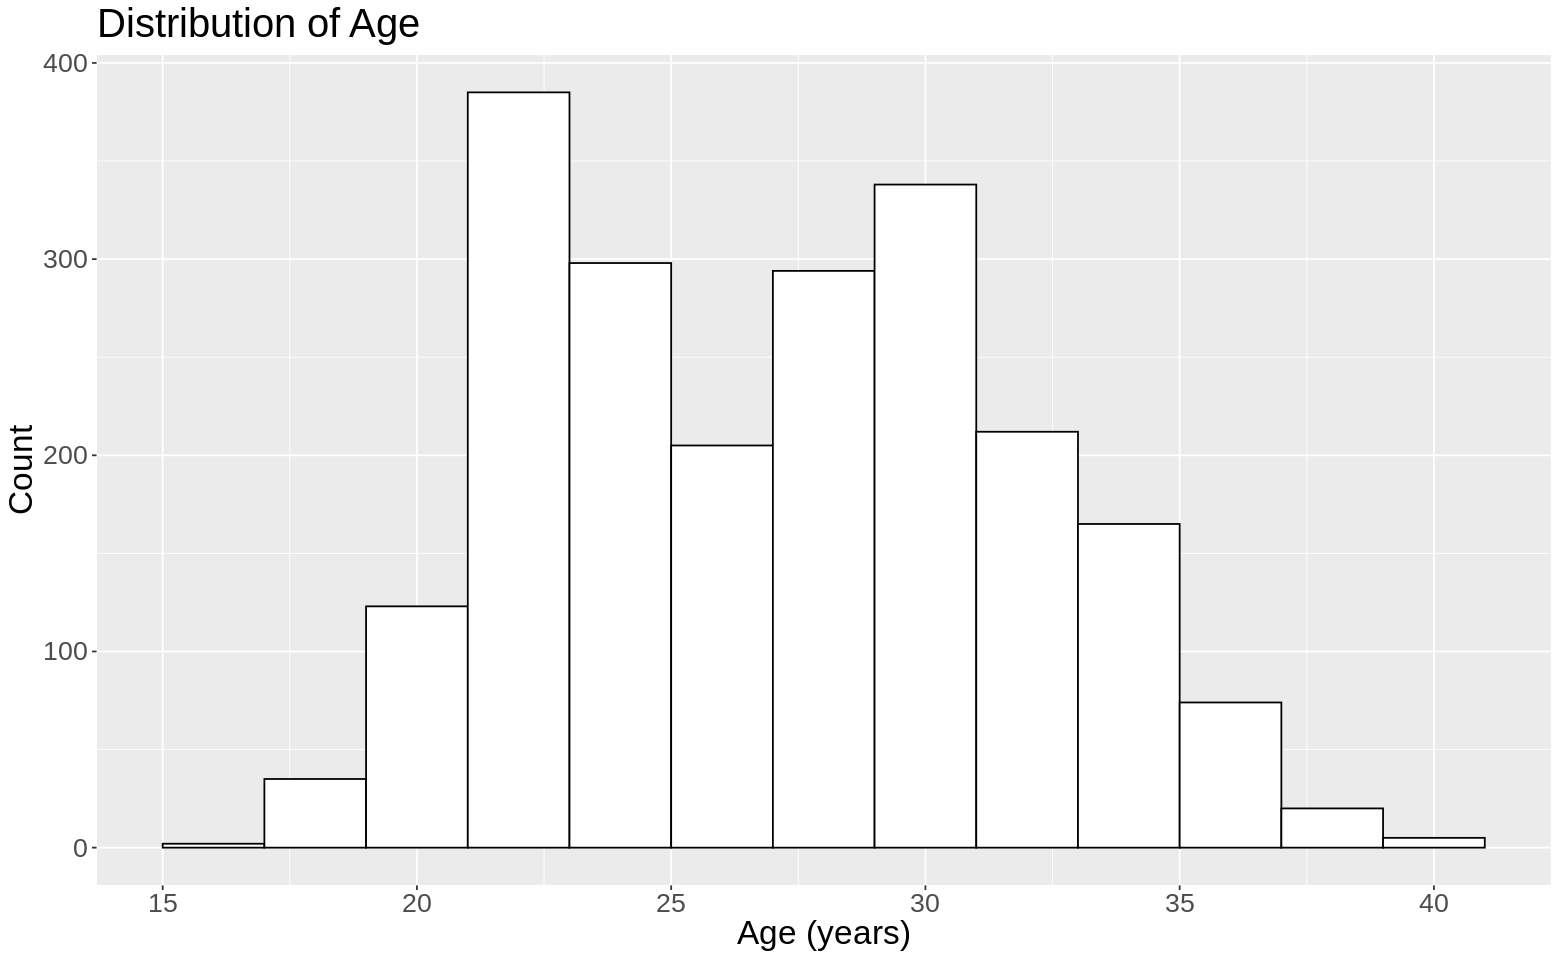

In [7]:
#Histograms of the height and age variable distributions ONLY USING TRAINING DATA
options(repr.plot.width = 13, repr.plot.height =8)
prelim_hist_height <- ggplot(data = match_train, aes(x = ht))+
                geom_histogram(binwidth = 5, color = "black", fill = "white")+
                labs(x = "Height (cm)", y = "Count")+
                ggtitle("Distribution of Height")+
                theme(text = element_text(size = 20))

prelim_hist_height # Figure1.1

prelim_hist_age <- ggplot(data = match_train, aes(x = age))+
                geom_histogram(binwidth = 2, color = "black", fill = "white")+
                labs(x = "Age (years)", y = "Count")+
                ggtitle("Distribution of Age")+
                theme(text = element_text(size = 20))
prelim_hist_age # Figure1.2

In [39]:
#to check the percentage of winning and losing in the data set to make sure one don't outweight the other
match_proportions <- match_train |>
                      group_by(match_result) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(match_train))

match_proportions #table 1.4

match_result,n,percent
<fct>,<int>,<dbl>
lose,1068,49.53618
win,1088,50.46382


In [9]:
#Change datatype of match_result from character to factor in order for the next few functions to work
match_train$match_result <- as.factor(match_train$match_result)
match_test$match_result <- as.factor(match_test$match_result)

In [10]:
#setup standard recipe, setup knn_spec to tune for k

match_recipe <- recipe(match_result ~ ht + age, data = match_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", 
                             neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

In [11]:
#try 10 different k values, every 3 from 1 to 30
k_vals <- tibble(neighbors = seq(from = 1, to = 30, by = 3))

match_vfold <- vfold_cv(match_train, v = 5, strata = match_result)

knn_results <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = match_vfold, grid = k_vals) |>
  collect_metrics() 

accuracies <- knn_results |>
  filter(.metric == "accuracy")

accuracies #table 1.5

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4949009,5,0.007389835,Preprocessor1_Model01
4,accuracy,binary,0.4902606,5,0.007407483,Preprocessor1_Model02
7,accuracy,binary,0.5296942,5,0.009239175,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
22,accuracy,binary,0.5246102,5,0.008742071,Preprocessor1_Model08
25,accuracy,binary,0.5097610,5,0.007144487,Preprocessor1_Model09
28,accuracy,binary,0.5097545,5,0.005610510,Preprocessor1_Model10


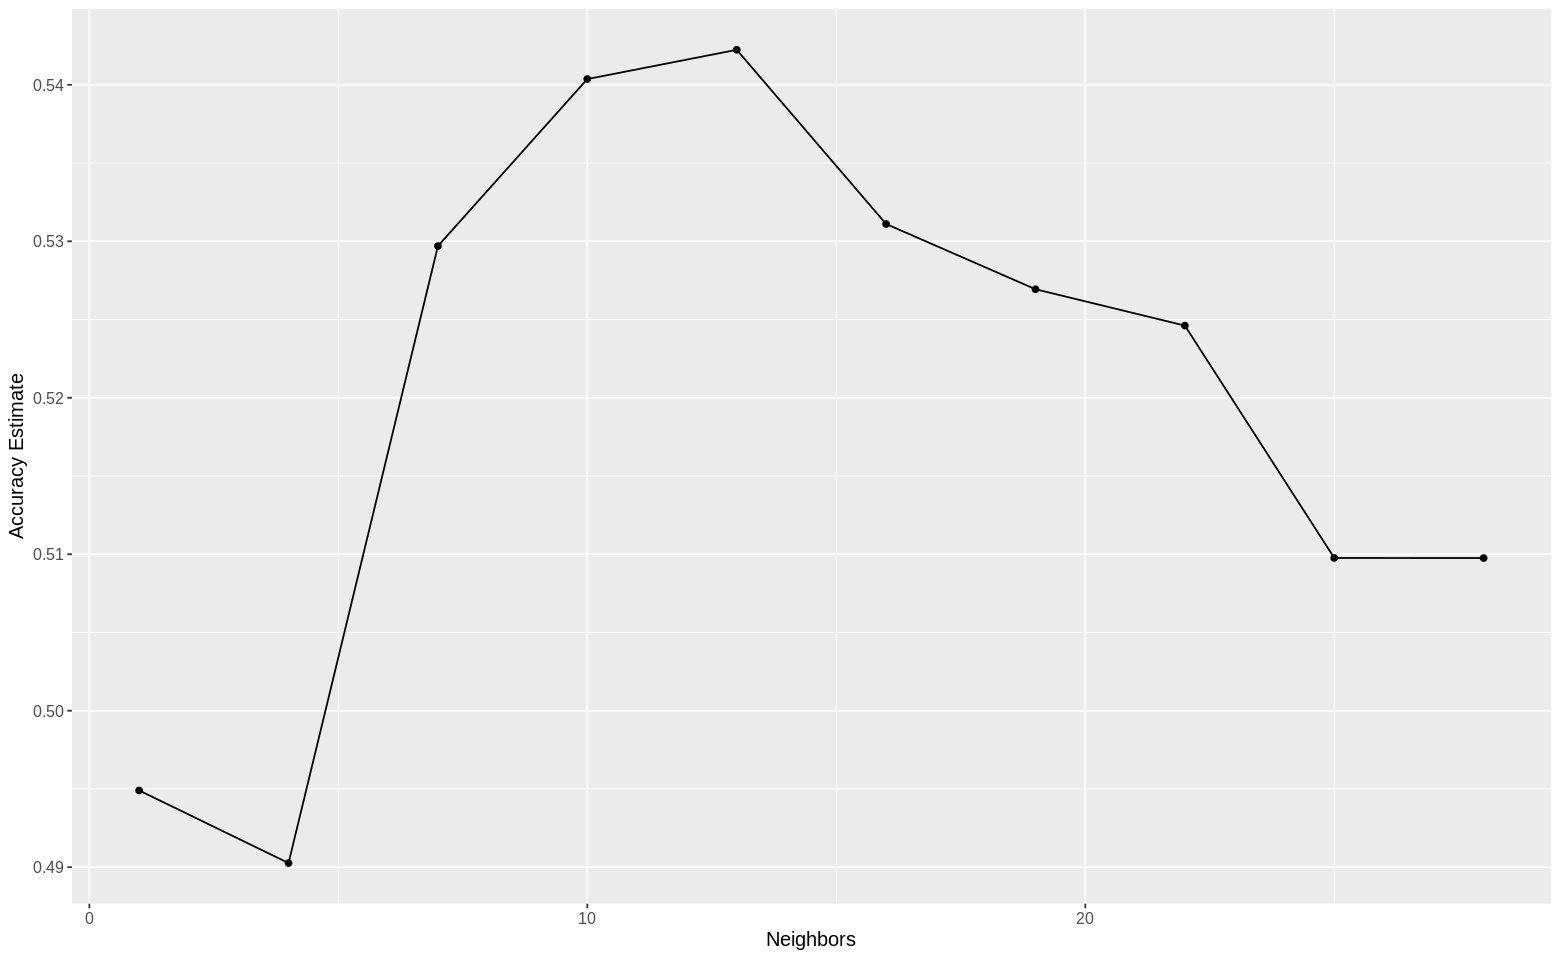

In [12]:
#plotting accuracies of different k, best seems to be 13
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k # Figure1.3

In [13]:
#display accuracy of model using best k and cross-validation 

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 13) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit_resamples(resamples = match_vfold)

knn_fit |> 
  collect_metrics() 

.metric,.estimator,mean,n,std_err,.config
<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
accuracy,binary,0.5422373,5,0.008441603,Preprocessor1_Model1
roc_auc,binary,0.5570012,5,0.008990000,Preprocessor1_Model1


In [14]:
#test predictions using test-data
knn_fit <- workflow() |>
  add_recipe(match_recipe) |>
  add_model(knn_spec) |>
  fit(match_train)

match_test_predictions <- predict(knn_fit, match_test) |>
  bind_cols(match_test)

match_test_predictions |>
  metrics(truth = match_result, estimate = .pred_class) |>
  filter(.metric == "accuracy")

confusion <- match_test_predictions |>
             conf_mat(truth = match_result, estimate = .pred_class)

match_test_predictions
confusion

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.5312067


.pred_class,ht,age,match_result
<fct>,<int>,<dbl>,<fct>
win,183,31.7,win
win,180,29.0,win
win,188,32.6,win
⋮,⋮,⋮,⋮
win,181,31.2,lose
lose,185,27.8,lose
lose,188,32.7,lose


          Truth
Prediction lose win
      lose  207 187
      win   151 176

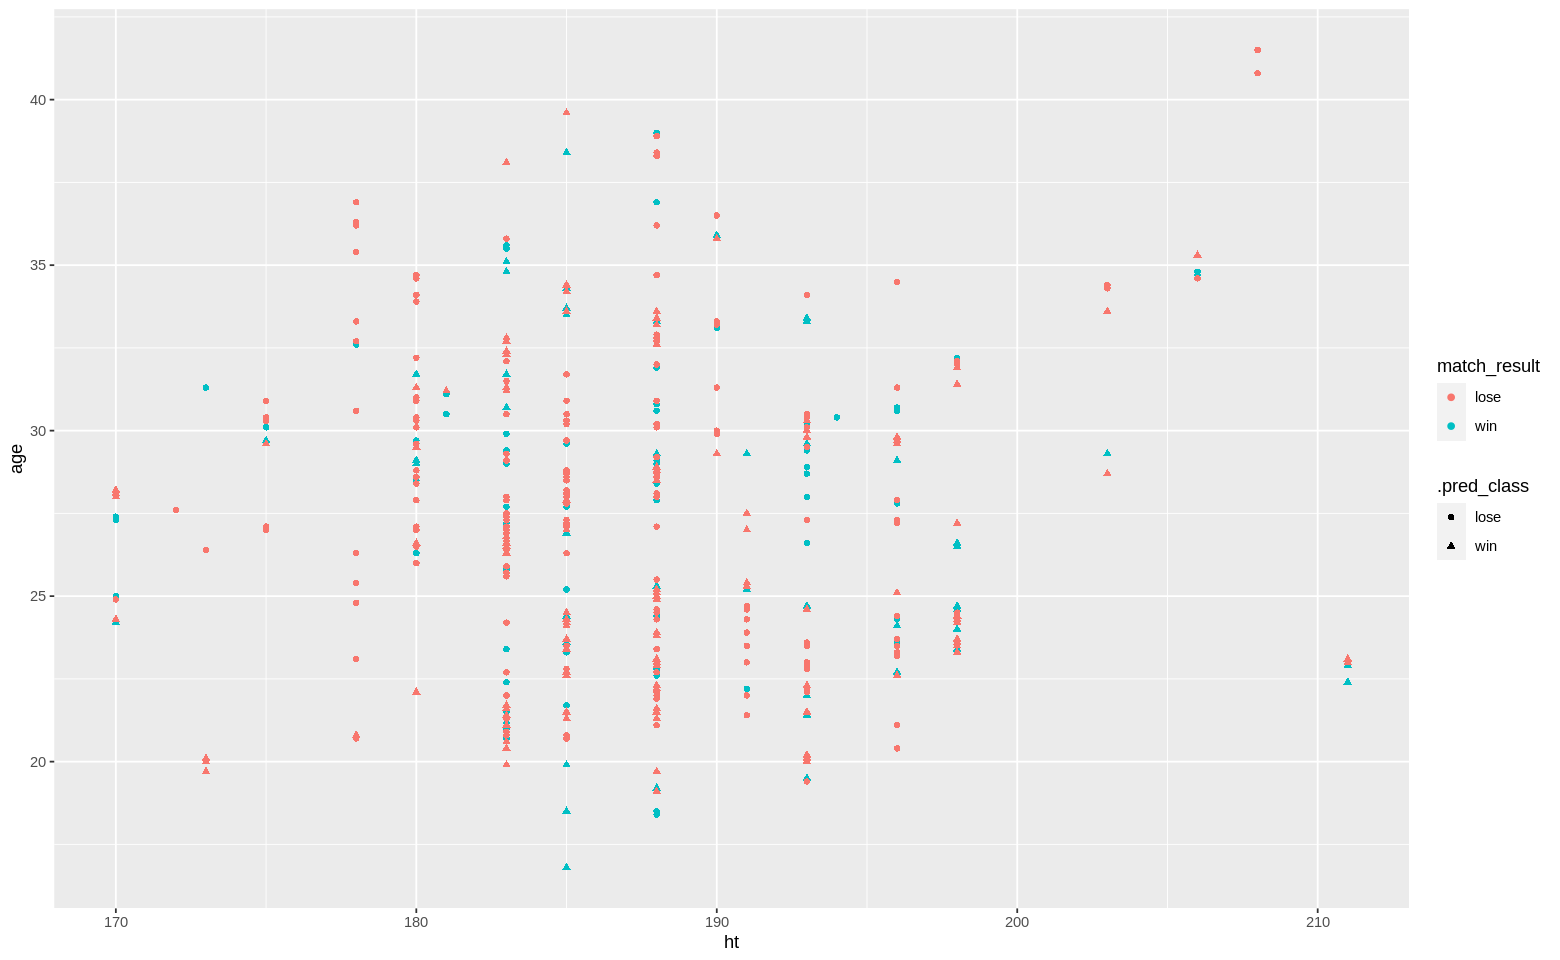

In [15]:
#graph plotting predictions v real values, still needs formatting 
prediction_plot <- ggplot(data = match_test_predictions,aes(x= ht, y=age, color = match_result, shape = .pred_class))+
                        geom_point()
prediction_plot

# Method

We create a new observation and try to predict the class for the new observation by three ways. The first way is to visualize the data and to see where the point fit and classified as. The second way is to create a tibble for the new observation. Then we use the predict function and the model to predict the new observation's class type. The third way is to use the squared distance formula to pick out 13 nearest points as references to classify the new observation.


Warning message:
“Removed 47 rows containing missing values (geom_point).”


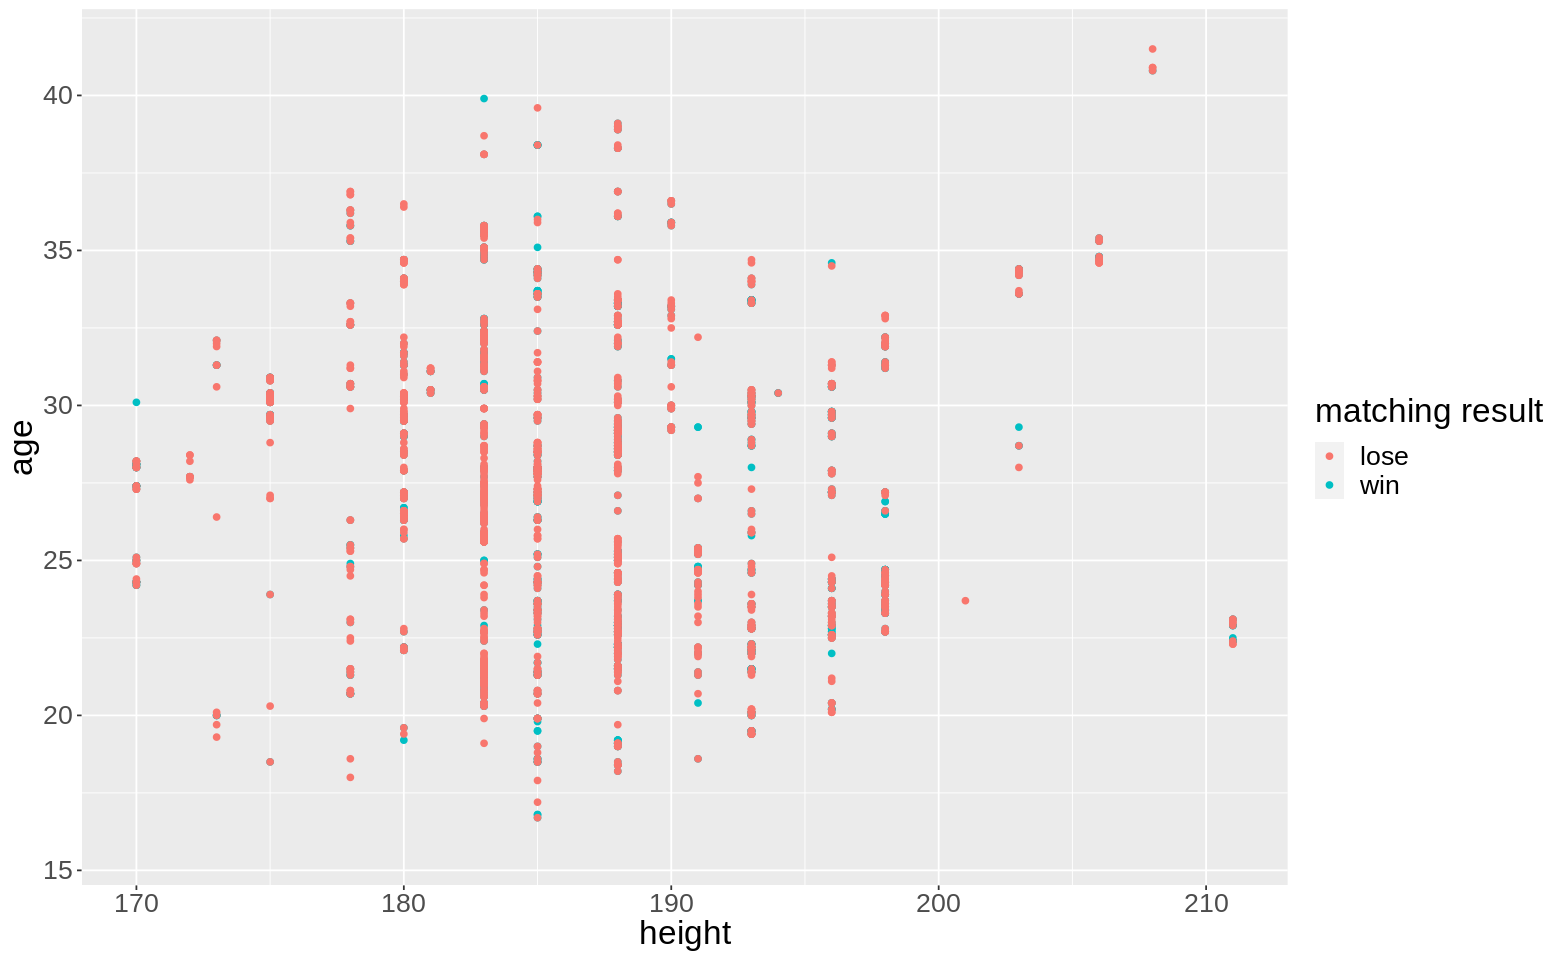

In [33]:
#method 1
point1 <- c(180,30)

ht_vs_age <- match_data_tidy |>
    ggplot(aes(x = ht, 
               y = age, 
               colour = match_result)) +
        labs(x = "height",
             y = "age",
            colour = 'matching result') +
        geom_point() + theme(text = element_text(size = 20))
        
ht_vs_age

In [22]:
#method 2
new_obs <- tibble(ht = 180, age = 30)

obs_prediction <- predict(knn_fit, new_obs)

obs_prediction

.pred_class
<fct>
lose


In [38]:
#method 3
new_obs_ht <- 180
new_obs_age <- 30

ht_age <- match_data_tidy |> mutate(dist_from_new_obs = sqrt((ht - new_obs_ht)^2 + 
                                                             (age - new_obs_age)^2)) |>
arrange(dist_from_new_obs) |> head(13)

ht_age

,ht,age,match_result,dist_from_new_obs
,<int>,<dbl>,<chr>,<dbl>
1,180,30.1,lose,0.1
2,180,30.1,lose,0.1
3,180,30.1,lose,0.1
⋮,⋮,⋮,⋮,⋮
11,180,30.2,lose,0.2
12,180,29.8,lose,0.2
13,180,30.2,lose,0.2


## Discussion:

Our findings 

TO BE FILLED IN

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead to?



## References:

At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
Make sure to cite the source of your data as well

